In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import turbofats

## Create a lightcurve

In [2]:
n_samples = 400
n_days = 100
n_components = 7
period = 7.4
std = 0.5
time = np.random.rand(n_samples) * n_days
time.sort()
time = time.reshape(-1, 1)
cosine_components = np.random.randn(1, n_components) * np.exp(-np.linspace(0, 4, n_components))
sine_components = np.random.randn(1, n_components) * np.exp(-np.linspace(0, 4, n_components))
bias = np.random.randn(1) * 5

time_arg = 2*np.pi*time/(period/np.arange(1, n_components+1).reshape(1, n_components))
magnitude = np.sum(cosine_components * np.cos(time_arg) + sine_components * np.sin(time_arg), axis=1) + bias

error = np.ones(n_samples)*std + np.random.rand(n_samples)*std*3

magnitude += error

(400, 1) (400,)


<ErrorbarContainer object of 3 artists>

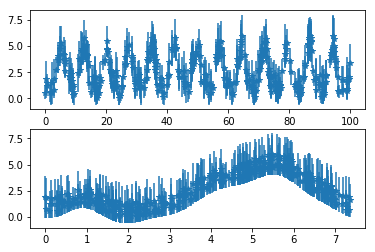

In [3]:
print(time.shape, magnitude.shape)
plt.subplot(2, 1, 1)
plt.errorbar(time, magnitude, yerr=error, fmt='*')
plt.subplot(2, 1, 2)
plt.errorbar(time % period, magnitude, yerr=error, fmt='*')

In [4]:
feature_space = turbofats.NewFeatureSpace(feature_list=['PeriodLS_v2', 'Period_fit_v2', 'Harmonics'])

In [5]:
detections_data = np.stack(
    [
        time.flatten(),
        magnitude.flatten(),
        error
    ],
    axis=-1
)
detections = pd.DataFrame(
    data=detections_data,
    columns=['mjd', 'magpsf_corr', 'sigmapsf_corr'],
    index=['asdf'] * len(detections_data)
)
feature_values = feature_space.calculate_features(detections)

In [6]:
print(cosine_components)
print(sine_components)
print(np.sqrt(cosine_components**2 + sine_components**2))
feature_values

[[-0.44872882 -0.44532385 -0.29239976 -0.09740294 -0.06809273 -0.03359103
  -0.01105452]]
[[-1.88134956  0.46366916  0.25203331  0.06925586 -0.17988312 -0.02741089
  -0.01277977]]
[[1.9341235  0.64288601 0.38602903 0.11951446 0.19233968 0.04335567
  0.01689749]]


,PeriodLS_v2,Period_fit_v2,Harmonics_mag_1,Harmonics_mag_2,Harmonics_mag_3,Harmonics_mag_4,Harmonics_mag_5,Harmonics_mag_6,Harmonics_mag_7,Harmonics_phase_2,Harmonics_phase_3,Harmonics_phase_4,Harmonics_phase_5,Harmonics_phase_6,Harmonics_phase_7,Harmonics_mse
oid,,,,,,,,,,,,,,,,
asdf,7.390982,0.321647,1.94791,0.639835,0.415904,0.105966,0.15394,0.028275,0.025135,5.946607,1.695325,3.138947,0.695309,1.903248,4.107723,0.312921


In [7]:
reconstructed_period = feature_values['PeriodLS_v2'].values[0]
reconstructed_time_arg = 2*np.pi*time/(reconstructed_period/np.arange(1, n_components+1).reshape(1, n_components))
print(reconstructed_time_arg.shape)
reconstructed_harmonics_mag = np.array([feature_values['Harmonics_mag_%d' % i].values[0] for i in range(1, 8)])
reconstructed_harmonics_phase = np.array([0.0] + [feature_values['Harmonics_phase_%d' % i].values[0] for i in range(2, 8)])

reconstructed_mag = reconstructed_harmonics_mag.reshape(1, -1)*np.cos(reconstructed_time_arg - reconstructed_harmonics_phase.reshape(1, -1))
reconstructed_mag = np.real(np.sum(reconstructed_mag, axis=1) + np.mean(magnitude))

(400, 7)


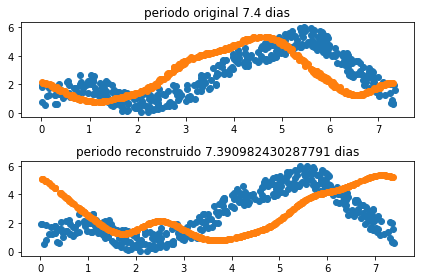

In [8]:
plt.subplot(2, 1, 1)
plt.scatter(time % period, magnitude)
plt.scatter((time - 3.0) % period, reconstructed_mag)
plt.title(f'periodo original {period} dias')
plt.subplot(2, 1, 2)
plt.scatter(time % reconstructed_period, magnitude)
plt.scatter((time-0.5) % reconstructed_period, reconstructed_mag)
plt.title(f'periodo reconstruido {reconstructed_period} dias')

plt.tight_layout()

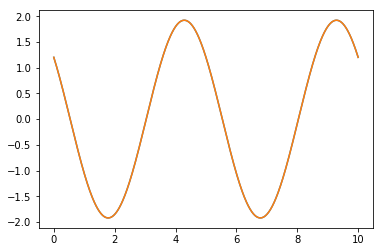

In [9]:
tt = np.linspace(0, 10, 1000)
a = 1.2
b = -1.5
f = 0.2
y = a*np.cos(2*np.pi*f*tt) + b*np.sin(2*np.pi*f*tt)
plt.plot(tt, y)
m = np.sqrt(a**2 + b**2)
phi = np.arctan2(b, a)
y2 = m*np.cos(2*np.pi*f*tt-phi)
plt.plot(tt, y2)

In [10]:
lc = pd.read_pickle('~/alerce/GP-Augmentation/results_paula/augmented_lightcurves.pkl')
lc.head()

,mjd,magpsf_corr,sigmapsf_corr,fid,detected,flux,maglim,ra,dec,rb,sgscore1,isdiffpos
oid,,,,,,,,,,,,
ZTF19aanfqug_augmented0,58268.423588,30.000000,0.500000,1,False,1.000000e-30,19.6402,150.176207,12.039854,0.321429,0.05025,1
ZTF19aanfqug_augmented0,58268.439525,30.000000,0.500000,1,False,1.000000e-30,19.5667,150.176216,12.039850,0.825714,0.05025,1
ZTF19aanfqug_augmented0,58274.423947,30.000000,0.500000,2,False,1.000000e-30,18.8384,150.176189,12.039860,0.928571,0.05025,1
ZTF19aanfqug_augmented0,58288.374178,30.000000,0.500000,2,False,1.000000e-30,19.5531,150.176211,12.039865,0.715714,0.05025,1
ZTF19aanfqug_augmented0,58288.434479,21.922829,0.209587,1,False,6.178292e-29,19.6352,150.176190,12.039840,0.897143,0.05025,1


In [11]:
detections = lc[lc.detected]
oids = detections.index.unique()
for oid in oids:
    one_lc = detections.loc[oid]
    feature_values = feature_space.calculate_features(one_lc)
    print(oid,)

ZTF19aanfqug_augmented0
ZTF19aanfqug_augmented1
ZTF19aanfqug_augmented2
ZTF19aanfqug_augmented3
ZTF19aanfqug_augmented4
ZTF19aanfqug_augmented5
ZTF19aanfqug_augmented6
ZTF19aanfqug_augmented7
ZTF19aanfqug_augmented8
ZTF19aanfqug_augmented9
ZTF19aanfqug_augmented10
ZTF19aanfqug_augmented11
ZTF19aanfqug_augmented12
ZTF19aanfqug_augmented13
ZTF19aanfqug_augmented14
ZTF19aanfqug_augmented15
ZTF19aanfqug_augmented16
ZTF19aanfqug_augmented17
ZTF19aanfqug_augmented18
ZTF19aanfqug_augmented19
ZTF19aanfqug_augmented20
ZTF19aanfqug_augmented21
ZTF19aanfqug_augmented22
ZTF19aanqzhm_augmented0
ZTF19aanqzhm_augmented1
ZTF19aanqzhm_augmented2
ZTF19aanqzhm_augmented3
ZTF19aanqzhm_augmented4
ZTF19aanqzhm_augmented5
ZTF19aanqzhm_augmented6
ZTF19aanqzhm_augmented7
ZTF19aanqzhm_augmented8
ZTF19aanqzhm_augmented9
ZTF19aanqzhm_augmented10
ZTF19aanqzhm_augmented11
ZTF19aanqzhm_augmented12
ZTF19aanqzhm_augmented13
ZTF19aanqzhm_augmented14
ZTF19aanqzhm_augmented15
ZTF19aanqzhm_augmented16
ZTF19aanqzhm_augment

ZTF18abxbmqh_augmented13
ZTF18abxbmqh_augmented14
ZTF18abxbmqh_augmented15
ZTF18abxbmqh_augmented16
ZTF18abxbmqh_augmented17
ZTF18abxbmqh_augmented18
ZTF18abxbmqh_augmented19
ZTF18abxbmqh_augmented20
ZTF18abxbmqh_augmented21
ZTF18abxbmqh_augmented22
ZTF19aaruixj_augmented0
ZTF19aaruixj_augmented1
ZTF19aaruixj_augmented2
ZTF19aaruixj_augmented3
ZTF19aaruixj_augmented4
ZTF19aaruixj_augmented5
ZTF19aaruixj_augmented6
ZTF19aaruixj_augmented7
ZTF19aaruixj_augmented8
ZTF19aaruixj_augmented9
ZTF19aaruixj_augmented10
ZTF19aaruixj_augmented11
ZTF19aaruixj_augmented12
ZTF19aaruixj_augmented13
ZTF19aaruixj_augmented14
ZTF19aaruixj_augmented15
ZTF19aaruixj_augmented16
ZTF19aaruixj_augmented17
ZTF19aaruixj_augmented18
ZTF19aaruixj_augmented19
ZTF19aaruixj_augmented20
ZTF19aaruixj_augmented21
ZTF19aaruixj_augmented22
ZTF18acnnevs_augmented0
ZTF18acnnevs_augmented1
ZTF18acnnevs_augmented2
ZTF18acnnevs_augmented3
ZTF18acnnevs_augmented4
ZTF18acnnevs_augmented5
ZTF18acnnevs_augmented6
ZTF18acnnevs_augm

ZTF19aadgimr_augmented3
ZTF19aadgimr_augmented4
ZTF19aadgimr_augmented5
ZTF19aadgimr_augmented6
ZTF19aadgimr_augmented7
ZTF19aadgimr_augmented8
ZTF19aadgimr_augmented9
ZTF19aadgimr_augmented10
ZTF19aadgimr_augmented11
ZTF19aadgimr_augmented12
ZTF19aadgimr_augmented13
ZTF19aadgimr_augmented14
ZTF19aadgimr_augmented15
ZTF19aadgimr_augmented16
ZTF19aadgimr_augmented17
ZTF19aadgimr_augmented18
ZTF19aadgimr_augmented19
ZTF19aadgimr_augmented20
ZTF19aadgimr_augmented21
ZTF19aadgimr_augmented22
ZTF19abdviwl_augmented0
ZTF19abdviwl_augmented1
ZTF19abdviwl_augmented2
ZTF19abdviwl_augmented3
ZTF19abdviwl_augmented4
ZTF19abdviwl_augmented5
ZTF19abdviwl_augmented6
ZTF19abdviwl_augmented7
ZTF19abdviwl_augmented8
ZTF19abdviwl_augmented9
ZTF19abdviwl_augmented10
ZTF19abdviwl_augmented11
ZTF19abdviwl_augmented12
ZTF19abdviwl_augmented13
ZTF19abdviwl_augmented14
ZTF19abdviwl_augmented15
ZTF19abdviwl_augmented16
ZTF19abdviwl_augmented17
ZTF19abdviwl_augmented18
ZTF19abdviwl_augmented19
ZTF19abdviwl_augm

ZTF19aaxfcpq_augmented11
ZTF19aalouag_augmented0
ZTF19aalouag_augmented1
ZTF19aalouag_augmented2
ZTF19aalouag_augmented3
ZTF19aalouag_augmented4
ZTF19aalouag_augmented5
ZTF19aalouag_augmented6
ZTF19aalouag_augmented7
ZTF19aalouag_augmented8
ZTF19aalouag_augmented9
ZTF19aalouag_augmented10
ZTF19aalouag_augmented11
ZTF19aavkvpw_augmented0
ZTF19aavkvpw_augmented1
ZTF19aavkvpw_augmented2
ZTF19aavkvpw_augmented3
ZTF19aavkvpw_augmented4
ZTF19aavkvpw_augmented5
ZTF19aavkvpw_augmented6
ZTF19aavkvpw_augmented7
ZTF19aavkvpw_augmented8
ZTF19aavkvpw_augmented9
ZTF19aavkvpw_augmented10
ZTF19aavkvpw_augmented11
ZTF19aavouyw_augmented0
ZTF19aavouyw_augmented1
ZTF19aavouyw_augmented2
ZTF19aavouyw_augmented3
ZTF19aavouyw_augmented4
ZTF19aavouyw_augmented5
ZTF19aavouyw_augmented6
ZTF19aavouyw_augmented7
ZTF19aavouyw_augmented8
ZTF19aavouyw_augmented9
ZTF19aavouyw_augmented10
ZTF19aavouyw_augmented11
ZTF19abfsxpw_augmented0
ZTF19abfsxpw_augmented1
ZTF19abfsxpw_augmented2
ZTF19abfsxpw_augmented3
ZTF19abfs

KeyboardInterrupt: 